In [38]:
# aim: don't change the overall approach, but try to at least overfit the training data

# also: plot values of weights (norms of matrices?) to debug and see if GD is still updating
# (why are the outputs sometimes unchanging with respect to iterations of GD?)

In [39]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean

%matplotlib inline
plt.style.use('ggplot')

In [40]:
# predict bearish/bullish signal for the next month based on price data from previous 6 months
# 1 - net positive return over the subsequent month. 0 - net negative return over the subsequent month. 

timelinedata = pd.read_csv('timeline-data/IBM-timeline-data.csv')

features = pd.read_csv('timeline-data/IBM-features.csv')
targets = pd.read_csv('timeline-data/IBM-targets.csv')
targets = targets.apply(lambda x: x > 0).astype(int)

In [41]:
# historical price data suggests an approximate random walk. (about as many bullish months as bearish)

targets.sum()/len(targets)

0    0.537953
dtype: float64

In [42]:
# net return over the entire period. equivalently, we could take the geometric mean..that'd just be taking the n-th root

sixmonthreturns = []

for i in range(len(features)):
    sixmonthreturns.append(np.prod(features.iloc[i]+1)-1)
    
sixmonthreturns = np.array(sixmonthreturns)

In [43]:
# net return over each half (3 month period)

threemonthreturns = []

for i in range(len(features)):
    threemonthreturns.append([np.prod(features.iloc[i][:63]+1)-1,np.prod(features.iloc[i][63:]+1)-1])
    
threemonthreturns = np.array(threemonthreturns)

In [44]:
# net return over each third (2 month period)

twomonthreturns = []

for i in range(len(features)):
    twomonthreturns.append([np.prod(features.iloc[i][0:42]+1)-1,
                            np.prod(features.iloc[i][42:84]+1)-1,
                            np.prod(features.iloc[i][84:]+1)-1])
    
twomonthreturns = np.array(twomonthreturns)

In [45]:
# col 0 - 6 month return. col 1 - first 3 month return. col 2 - seocnd 3 month return. col 3 - first 2 month return
# col 4 - second 2 month return. col 5 - third 2 month return. 

# is it a good idea to mix all the periods like this..? to be seen if there is an underlying function of the cycles
# that will be approximated by the feed forward NN

# will not bother with normalizing the inputs for now.. since all the inputs are on the same scale already

# RNN is probably a better approach

final_features = pd.DataFrame(sixmonthreturns)
final_features[1] = threemonthreturns[:,0]
final_features[2] = threemonthreturns[:,1]
final_features[3] = twomonthreturns[:,0]
final_features[4] = twomonthreturns[:,1]
final_features[5] = twomonthreturns[:,2]

for col in final_features.columns:
    final_features[col] = (final_features[col] - final_features[col].mean())/final_features[col].std()

In [50]:
# .drop() to remove the 2-month periods. they may be adding more noise than value..too many inputs

features_train = final_features[:-1000]#.drop([3,4,5],axis=1)
targets_train = targets[:-1000]

features_test = final_features[-1000:]#.drop([3,4,5],axis=1)
targets_test = targets[-1000:]

In [91]:
# for larger networks, the parameters don't seem to update unless the the learning rate is reduced... why? 

import tensorflow as tf

model = tf.keras.Sequential()

layer_hidden_units = [7,7,6,6,6,5,5,5,4,4,4,3,2,1]

for i,hu in enumerate(layer_hidden_units):
    if i == 0: # need to specify input dimensions for the first layer
        model.add(tf.keras.layers.Dense(hu,activation='relu',input_dim=6,
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=np.sqrt(1/3))))
        model.add(tf.keras.layers.BatchNormalization())
        continue
    if i == len(layer_hidden_units)-1: # output layer has different activation
        model.add(tf.keras.layers.Dense(hu,
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=np.sqrt(2/layer_hidden_units[i-1])),
                                        activation='sigmoid'))
        continue
        
    model.add(tf.keras.layers.Dense(hu,
                                    activation='relu',
                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=np.sqrt(2/layer_hidden_units[i-1]))))
    model.add(tf.keras.layers.BatchNormalization())
    
    
    
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [97]:
# can also instead use train_on_batch to use SGD and evaluate between iterations of SGD 

import time

train_acc = []
test_acc = []
iters = 300

tic = time.time()
for i in range(iters):
    model.fit(features_train.values,targets_train.values,epochs=1,batch_size=len(features_train),verbose=0)
    train_acc.append(model.evaluate(features_train.values,targets_train.values,verbose=0)[1])
    test_acc.append(model.evaluate(features_test.values,targets_test.values,verbose=0)[1])
toc = time.time()
print(toc-tic)

164.85838079452515


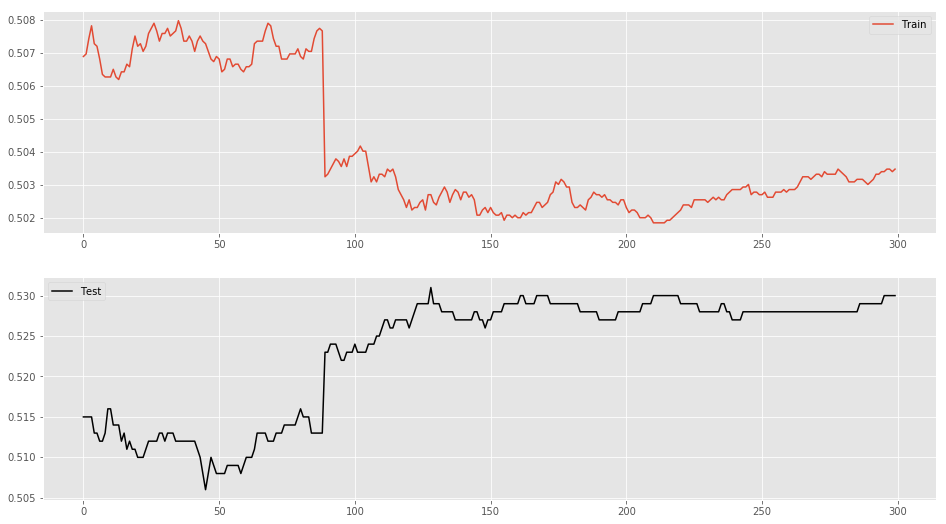

In [98]:
# performance level is not better than guessing (50-50 ish)
# test accuracy initially higher due to counts of each class (the untrained NN happens to predict more test cases correctly)

# 'iters' is no longer iterations. batch size is reduced to speed up convergence

# note that we get different results from training the network each time.. best way to evaluate results is to re-train
# the network several times (30+) and summarize results. we don't want the results to depend on deterministic initial conditions

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9))

ax1.plot(list(range(iters)),train_acc)
ax1.legend(['Train'])

ax2.plot(list(range(iters)),test_acc,color='k')
ax2.legend(['Test'],loc=2)
#ax.set_ylim([0,0.9])